In [8]:


from modules import EncoderNet,DecoderNet,DiscriminatorNet_reconstruction,GeneratorNet,TransNet,DiscriminatorNet_feature
from functional import noise
#from train import train,eval_generate
import resnet


import invresnet
import matplotlib.pylab as plt

from dataload import load_data ,batchfy 
from torchsummary import summary
import torch
from torch import nn,optim

In [9]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [10]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
train_load,test_load=batchfy(batch_size=256)

In [12]:
show_img=iter(train_load)

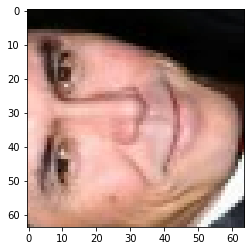

In [13]:
for batch_i, (real_images, gender,glasses) in enumerate(train_load):
    debug=real_images[0]
    plt.imshow((debug.numpy().transpose((1, 2, 0))*0.5)+0.5)
    break

In [14]:
len(train_load)

693

In [15]:
Encoder=resnet.resnet18()
Encoder.to(device)

Decoder=invresnet.invresnet18()
Decoder.to(device)

Generator=GeneratorNet(Encoder,Decoder)
Generator.to(device)
Discriminator_reconstruct=DiscriminatorNet_reconstruction(3,64)
Discriminator_reconstruct.to(device)

Discriminator_feature=DiscriminatorNet_feature()
Discriminator_feature.to(device)
print("model_loaded")

debug=torch.randn((1,99))
debug.to(device)
Decoder(debug).shape

model_loaded


torch.Size([1, 3, 64, 64])

In [16]:


Decoder(torch.rand(2,99).to(device)).shape

torch.Size([2, 3, 64, 64])

In [21]:
dr_optimizer = optim.Adam(Discriminator_reconstruct.parameters(), lr=0.00005, betas=(0.5, 0.999))
df_optimizer = optim.Adam(Discriminator_feature.parameters(), lr=0.00005, betas=(0.5, 0.999))
g_optimizer = optim.Adam(Generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
e_optimizer = optim.Adam(Encoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(Decoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
#print("modules Loaded")
num_epochs=20

In [22]:
import time
from torchvision import transforms, utils

In [23]:
def real_data_target(size):
    data = torch.ones(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    data = torch.zeros(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def real_feature_target(size):
    data = torch.ones(size, 10)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_feature_target(size):
    data = torch.zeros(size, 1,10)
    if torch.cuda.is_available(): return data.cuda()
    return data

def reconstruction_loss(optimizer,real_data,Generator):
    reconstruction=Generator(real_data)
    loss = nn.L1Loss()
    optimizer.zero_grad()
    error_recons=loss(real_data,reconstruction)
    error_recons.backward()
    optimizer.step()
    return error_recons
def d_adv_feature_loss(minimizing,real_data,fake_data,Discriminator,optimizer1,optimizer2):
    loss=nn.BCELoss()
    if minimizing:
        optimizer1.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_feature_target(real_data.size(0)))
        error_real.backward()   
        
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_feature_target(real_data.size(0)))
        error_fake.backward()
        optimizer1.step()        
        return error_real+error_fake
    else:
        optimizer2.zero_grad()
        prediction = Discriminator(fake_data)
        error = loss(prediction, real_feature_target(prediction.size(0)))
        error.backward()
        optimizer2.step()
    return error

def gen_image_loss(minimizing,
                   real_data,
                   fake_data,
                   Discriminator,
                   optimizer1,
                   optimizer2):
    def dloss_calc(optimizer, real_data, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake, prediction_real, prediction_fake
    def gloss_calc(optimizer, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction = Discriminator(fake_data)
        error = loss(prediction, real_data_target(prediction.size(0)))
        error.backward()
        optimizer.step()
        return error
    
    loss = nn.BCELoss()
        
    if minimizing:
        return dloss_calc(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc(optimizer2,fake_data,Discriminator)

def noise_vector(size):
    n = torch.randn(size, 1,99)
    if torch.cuda.is_available(): return n.cuda() 
    return n

def eval_generate(Decoder,num_images):
    Decoder.eval()
    noi_input=noise_vector(num_images)
    output=Decoder(noi_input)
    output=output.detach().cpu()
    plt.figure(figsize=(16, 16))
    grid_border_size = 2
    grid = utils.make_grid(output)
    
    plt.imshow((grid.numpy().transpose((1, 2, 0))*0.5)+0.5)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def train(num_epochs,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load):
    t_start = time.time()
    duration_avg = 0.0
    Encoder.train()
    Decoder.train()
    Generator.train()
    Discriminator_reconstruct.train()
    Discriminator_feature.train()
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        for batch_i, (real_images, gender,glasses) in enumerate(train_load):        
 
            batch_size = real_images.size(0)
            real_images=real_images.to(device,dtype=torch.float)
            noi = noise_vector(real_images.size(0))

            # 1.Train Discriminator
            fake_data = Decoder(noi).detach()

            d_error, d_pred_real, d_pred_fake =gen_image_loss(True,
                                                              real_images.float(), 
                                                              fake_data,Discriminator_reconstruct,
                                                              dr_optimizer,d_optimizer)
    
            # 2. Train Generator
            fake_data = Decoder(noi)#noise(real_batch.size(0)))
            # Train G
            g_error = gen_image_loss(False,                                    
                            real_images.float(), fake_data,Discriminator_reconstruct,dr_optimizer,d_optimizer)
            # 3. Train Reconstruction
            
            recons_loss=reconstruction_loss(g_optimizer,real_images.float(),Generator)
            
            # Display Progress
            if (batch_i) % 100 == 0:
                print("Discriminator_Error: ", d_error.item()," Generator_Error: ", g_error.item()," Recons_Error: ", recons_loss.item())
    
        t_end = time.time()
        duration_avg = (t_end - t_start) / (epoch + 1.0)
        print("Elapsed Time: ",duration_avg)
        torch.save(Encoder,'Encoder.h')
        torch.save(Decoder,'Encoder.h')
        torch.save(Discriminator_feature,'Discriminator_feature1.h')
        torch.save(Discriminator_reconstruct,'Discriminator_reconstruct1.h')
        eval_generate(Decoder,8)

Epoch: 0
Discriminator_Error:  1.3871850967407227  Generator_Error:  0.6895776987075806  Recons_Error:  0.6296555399894714
Discriminator_Error:  1.3862766027450562  Generator_Error:  0.6931829452514648  Recons_Error:  0.15882521867752075
Discriminator_Error:  1.3862957954406738  Generator_Error:  0.6935461163520813  Recons_Error:  0.12374486774206161
Discriminator_Error:  1.3863296508789062  Generator_Error:  0.6930655241012573  Recons_Error:  0.11892324686050415
Discriminator_Error:  1.3862957954406738  Generator_Error:  0.6932739019393921  Recons_Error:  0.10895514488220215
Discriminator_Error:  1.3862746953964233  Generator_Error:  0.6912890672683716  Recons_Error:  0.11340194940567017
Discriminator_Error:  1.3863451480865479  Generator_Error:  0.6942628622055054  Recons_Error:  0.10523003339767456
Elapsed Time:  452.32463812828064


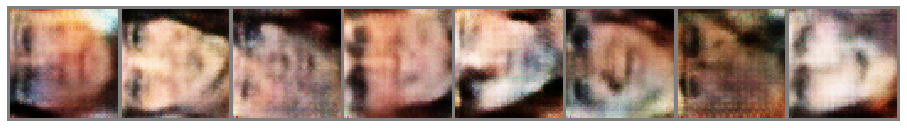

Epoch: 1
Discriminator_Error:  1.3862879276275635  Generator_Error:  0.6942609548568726  Recons_Error:  0.27894243597984314
Discriminator_Error:  1.3864188194274902  Generator_Error:  0.6957700848579407  Recons_Error:  0.13954780995845795
Discriminator_Error:  1.3863816261291504  Generator_Error:  0.6894851922988892  Recons_Error:  0.12497597187757492
Discriminator_Error:  1.3863248825073242  Generator_Error:  0.6922651529312134  Recons_Error:  0.10495272278785706
Discriminator_Error:  1.3862957954406738  Generator_Error:  0.6941448450088501  Recons_Error:  0.09957142919301987
Discriminator_Error:  1.386182427406311  Generator_Error:  0.6934770345687866  Recons_Error:  0.10195818543434143
Discriminator_Error:  1.3862557411193848  Generator_Error:  0.6944573521614075  Recons_Error:  0.10146265476942062
Elapsed Time:  456.21250903606415


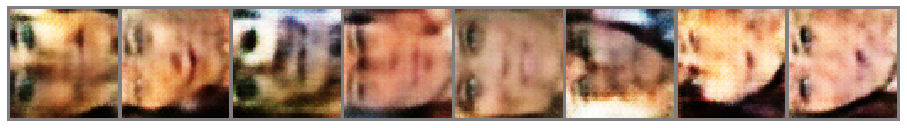

Epoch: 2
Discriminator_Error:  1.386322259902954  Generator_Error:  0.6918445825576782  Recons_Error:  0.10020816326141357
Discriminator_Error:  1.386230707168579  Generator_Error:  0.6918896436691284  Recons_Error:  0.10613002628087997
Discriminator_Error:  1.3862848281860352  Generator_Error:  0.6945844888687134  Recons_Error:  0.10207156836986542
Discriminator_Error:  1.3862661123275757  Generator_Error:  0.6923511624336243  Recons_Error:  0.10243658721446991
Discriminator_Error:  1.3862742185592651  Generator_Error:  0.6949738264083862  Recons_Error:  0.10451154410839081
Discriminator_Error:  1.3862686157226562  Generator_Error:  0.6923998594284058  Recons_Error:  0.094980888068676
Discriminator_Error:  1.3862910270690918  Generator_Error:  0.6937833428382874  Recons_Error:  0.09648256003856659
Elapsed Time:  457.33654197057086


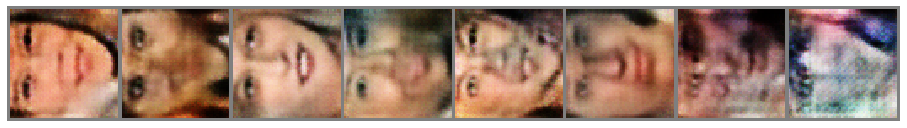

Epoch: 3
Discriminator_Error:  1.3862519264221191  Generator_Error:  0.6909261345863342  Recons_Error:  0.09871574491262436
Discriminator_Error:  1.3862557411193848  Generator_Error:  0.6924921870231628  Recons_Error:  0.09428666532039642
Discriminator_Error:  1.386284351348877  Generator_Error:  0.6941528916358948  Recons_Error:  0.0909418910741806
Discriminator_Error:  1.386365532875061  Generator_Error:  0.6936314105987549  Recons_Error:  0.0941934883594513
Discriminator_Error:  1.386337161064148  Generator_Error:  0.6922145485877991  Recons_Error:  0.09430190175771713
Discriminator_Error:  1.3863420486450195  Generator_Error:  0.6925601363182068  Recons_Error:  0.100566565990448
Discriminator_Error:  1.3863072395324707  Generator_Error:  0.6929118633270264  Recons_Error:  0.09037294238805771
Elapsed Time:  457.8678074479103


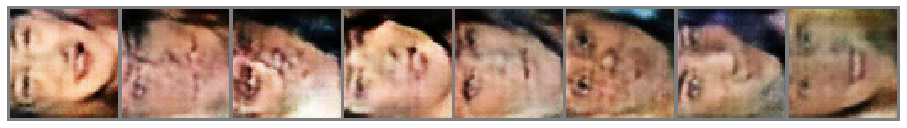

Epoch: 4
Discriminator_Error:  1.3863203525543213  Generator_Error:  0.6928260326385498  Recons_Error:  0.0912952646613121
Discriminator_Error:  1.386350154876709  Generator_Error:  0.6945158243179321  Recons_Error:  0.09018117189407349
Discriminator_Error:  1.3863074779510498  Generator_Error:  0.6944375038146973  Recons_Error:  0.09581790864467621
Discriminator_Error:  1.3863370418548584  Generator_Error:  0.6936129927635193  Recons_Error:  0.09251292794942856
Discriminator_Error:  1.3862545490264893  Generator_Error:  0.6926788091659546  Recons_Error:  0.09105687588453293
Discriminator_Error:  1.3863441944122314  Generator_Error:  0.6944805383682251  Recons_Error:  0.08993668854236603
Discriminator_Error:  1.3861963748931885  Generator_Error:  0.6914200782775879  Recons_Error:  0.09696396440267563
Elapsed Time:  458.34490423202516


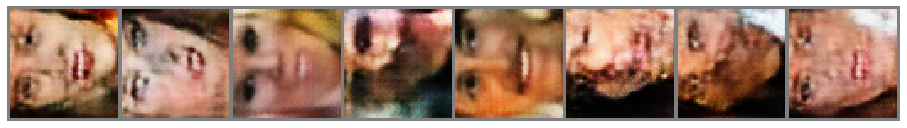

Epoch: 5
Discriminator_Error:  1.3862383365631104  Generator_Error:  0.6930196285247803  Recons_Error:  0.09615308046340942
Discriminator_Error:  1.386297583580017  Generator_Error:  0.6920449137687683  Recons_Error:  0.08786672353744507
Discriminator_Error:  1.3863027095794678  Generator_Error:  0.6932365298271179  Recons_Error:  0.08860829472541809
Discriminator_Error:  1.3863335847854614  Generator_Error:  0.69277024269104  Recons_Error:  0.08964549005031586
Discriminator_Error:  1.3862755298614502  Generator_Error:  0.6927126049995422  Recons_Error:  0.09019540250301361
Discriminator_Error:  1.386357307434082  Generator_Error:  0.6952236294746399  Recons_Error:  0.09598972648382187
Discriminator_Error:  1.386310338973999  Generator_Error:  0.6934117078781128  Recons_Error:  0.08751474320888519
Elapsed Time:  458.70047036806744


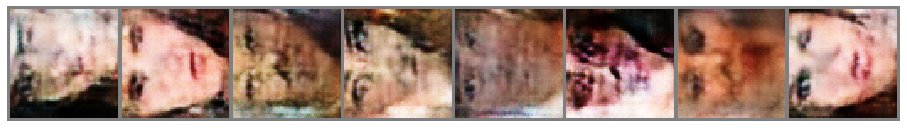

Epoch: 6
Discriminator_Error:  1.386381983757019  Generator_Error:  0.6905431747436523  Recons_Error:  0.09082075208425522
Discriminator_Error:  1.386338472366333  Generator_Error:  0.6917078495025635  Recons_Error:  0.08692508935928345
Discriminator_Error:  1.3863126039505005  Generator_Error:  0.6934359073638916  Recons_Error:  0.0880884975194931
Discriminator_Error:  1.3862216472625732  Generator_Error:  0.6919308304786682  Recons_Error:  0.08662766218185425
Discriminator_Error:  1.3863866329193115  Generator_Error:  0.6933616399765015  Recons_Error:  0.08930498361587524
Discriminator_Error:  1.3864071369171143  Generator_Error:  0.6930170655250549  Recons_Error:  0.08514996618032455
Discriminator_Error:  1.3862879276275635  Generator_Error:  0.6913301348686218  Recons_Error:  0.08799487352371216
Elapsed Time:  459.0527819905962


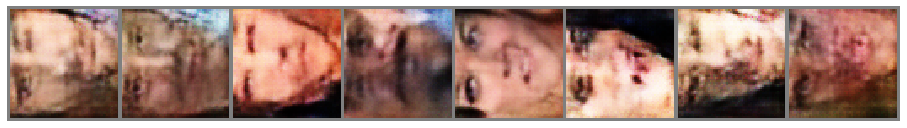

Epoch: 7
Discriminator_Error:  1.3862909078598022  Generator_Error:  0.6936252117156982  Recons_Error:  0.09244810789823532
Discriminator_Error:  1.3862533569335938  Generator_Error:  0.6963894367218018  Recons_Error:  0.0885225385427475
Discriminator_Error:  1.3863091468811035  Generator_Error:  0.6944323778152466  Recons_Error:  0.09255039691925049
Discriminator_Error:  1.3862957954406738  Generator_Error:  0.6946038007736206  Recons_Error:  0.08307593315839767
Discriminator_Error:  1.3863306045532227  Generator_Error:  0.6942794919013977  Recons_Error:  0.08932636678218842
Discriminator_Error:  1.3861777782440186  Generator_Error:  0.6941384077072144  Recons_Error:  0.08704503625631332
Discriminator_Error:  1.3863208293914795  Generator_Error:  0.6924198865890503  Recons_Error:  0.08950166404247284
Elapsed Time:  459.32345148921013


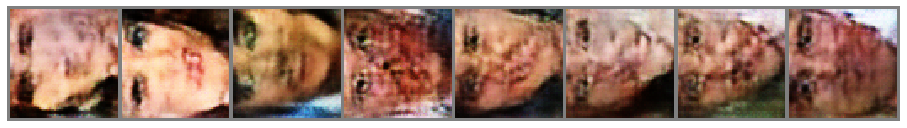

Epoch: 8
Discriminator_Error:  1.3862674236297607  Generator_Error:  0.6935852766036987  Recons_Error:  0.08355176448822021
Discriminator_Error:  1.3863118886947632  Generator_Error:  0.6940375566482544  Recons_Error:  0.08462382853031158
Discriminator_Error:  1.3863368034362793  Generator_Error:  0.6928601861000061  Recons_Error:  0.08775858581066132
Discriminator_Error:  1.3861600160598755  Generator_Error:  0.6901154518127441  Recons_Error:  0.09727521985769272
Discriminator_Error:  1.3862886428833008  Generator_Error:  0.6921347379684448  Recons_Error:  0.08395734429359436
Discriminator_Error:  1.386244297027588  Generator_Error:  0.6952253580093384  Recons_Error:  0.08533861488103867
Discriminator_Error:  1.3863499164581299  Generator_Error:  0.6942105293273926  Recons_Error:  0.08868460357189178
Elapsed Time:  459.463139851888


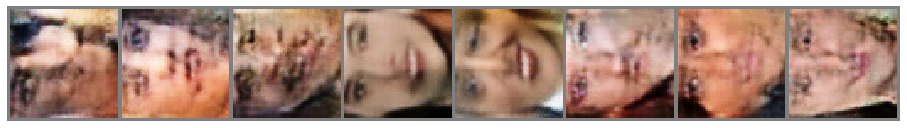

Epoch: 9
Discriminator_Error:  1.386357069015503  Generator_Error:  0.6931304335594177  Recons_Error:  0.08402092754840851
Discriminator_Error:  1.3863418102264404  Generator_Error:  0.6927946209907532  Recons_Error:  0.09279551357030869
Discriminator_Error:  1.3862888813018799  Generator_Error:  0.6927797198295593  Recons_Error:  0.08691059052944183
Discriminator_Error:  1.3862993717193604  Generator_Error:  0.6928293704986572  Recons_Error:  0.08399715274572372
Discriminator_Error:  1.386371374130249  Generator_Error:  0.6941055059432983  Recons_Error:  0.08508165925741196
Discriminator_Error:  1.3863701820373535  Generator_Error:  0.6916715502738953  Recons_Error:  0.09830692410469055
Discriminator_Error:  1.3864359855651855  Generator_Error:  0.6926690340042114  Recons_Error:  0.08773581683635712
Elapsed Time:  459.5125418186188


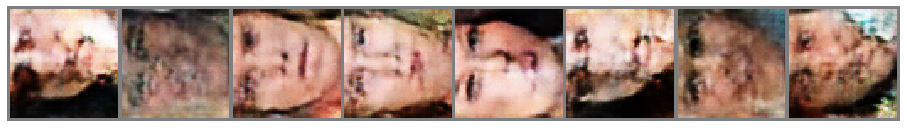

Epoch: 10
Discriminator_Error:  1.3861877918243408  Generator_Error:  0.6898969411849976  Recons_Error:  0.08761702477931976
Discriminator_Error:  1.386339783668518  Generator_Error:  0.6933644413948059  Recons_Error:  0.08570518344640732
Discriminator_Error:  1.3863470554351807  Generator_Error:  0.6931951642036438  Recons_Error:  0.09674079716205597
Discriminator_Error:  1.3863122463226318  Generator_Error:  0.6949640512466431  Recons_Error:  0.08704143017530441
Discriminator_Error:  1.3863343000411987  Generator_Error:  0.6934413909912109  Recons_Error:  0.08622188866138458
Discriminator_Error:  1.3863277435302734  Generator_Error:  0.6934103965759277  Recons_Error:  0.08329065144062042
Discriminator_Error:  1.3862617015838623  Generator_Error:  0.6943325996398926  Recons_Error:  0.08361002802848816
Elapsed Time:  459.6421794241125


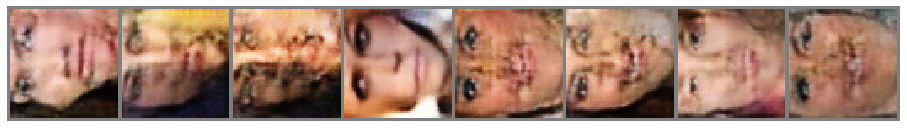

Epoch: 11
Discriminator_Error:  1.386308193206787  Generator_Error:  0.6941033601760864  Recons_Error:  0.08546872437000275
Discriminator_Error:  1.3863461017608643  Generator_Error:  0.6891785860061646  Recons_Error:  0.09172986447811127
Discriminator_Error:  1.3863201141357422  Generator_Error:  0.6938025951385498  Recons_Error:  0.08550097793340683
Discriminator_Error:  1.3863320350646973  Generator_Error:  0.6958552598953247  Recons_Error:  0.08878090232610703
Discriminator_Error:  1.386256456375122  Generator_Error:  0.6902951598167419  Recons_Error:  0.09022154659032822
Discriminator_Error:  1.3862780332565308  Generator_Error:  0.6949371695518494  Recons_Error:  0.08162720501422882
Discriminator_Error:  1.386279582977295  Generator_Error:  0.6942325830459595  Recons_Error:  0.08617895841598511
Elapsed Time:  459.768660446008


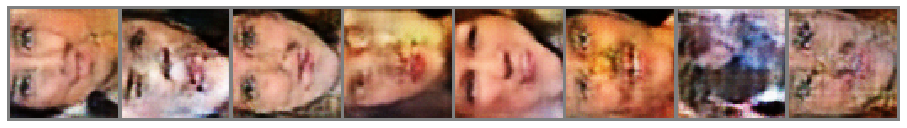

Epoch: 12
Discriminator_Error:  1.386309027671814  Generator_Error:  0.6938724517822266  Recons_Error:  0.08672235906124115
Discriminator_Error:  1.3863164186477661  Generator_Error:  0.6919170618057251  Recons_Error:  0.08266481012105942
Discriminator_Error:  1.3862972259521484  Generator_Error:  0.6929588913917542  Recons_Error:  0.08538784831762314
Discriminator_Error:  1.3863286972045898  Generator_Error:  0.6905863285064697  Recons_Error:  0.08326208591461182
Discriminator_Error:  1.3862663507461548  Generator_Error:  0.6948654055595398  Recons_Error:  0.0885918140411377
Discriminator_Error:  1.3863153457641602  Generator_Error:  0.6924878358840942  Recons_Error:  0.08344842493534088
Discriminator_Error:  1.386284589767456  Generator_Error:  0.6953227519989014  Recons_Error:  0.08392640948295593
Elapsed Time:  459.8980693083543


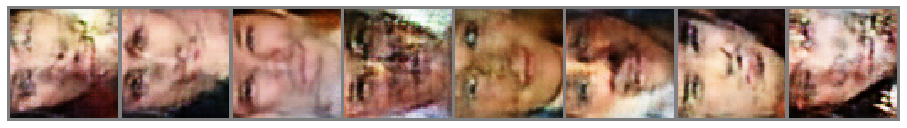

Epoch: 13
Discriminator_Error:  1.3863251209259033  Generator_Error:  0.6932345628738403  Recons_Error:  0.08388975262641907
Discriminator_Error:  1.386309027671814  Generator_Error:  0.6914334297180176  Recons_Error:  0.08798014372587204
Discriminator_Error:  1.3863306045532227  Generator_Error:  0.6940648555755615  Recons_Error:  0.08190439641475677
Discriminator_Error:  1.386332631111145  Generator_Error:  0.6915924549102783  Recons_Error:  0.08483035862445831
Discriminator_Error:  1.3863105773925781  Generator_Error:  0.6932979822158813  Recons_Error:  0.08505554497241974
Discriminator_Error:  1.386322259902954  Generator_Error:  0.6928001642227173  Recons_Error:  0.08223281055688858
Discriminator_Error:  1.3862957954406738  Generator_Error:  0.6935762166976929  Recons_Error:  0.08274954557418823
Elapsed Time:  459.97246071270536


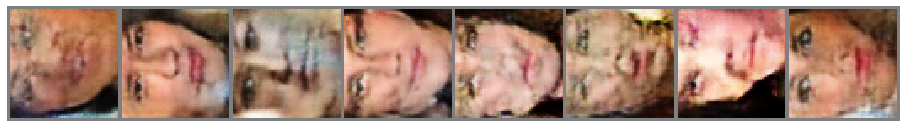

Epoch: 14
Discriminator_Error:  1.386286735534668  Generator_Error:  0.6912617683410645  Recons_Error:  0.09145426750183105
Discriminator_Error:  1.3863102197647095  Generator_Error:  0.6907244920730591  Recons_Error:  0.08815161883831024
Discriminator_Error:  1.3863115310668945  Generator_Error:  0.6930761337280273  Recons_Error:  0.08042807132005692
Discriminator_Error:  1.3863270282745361  Generator_Error:  0.6938804388046265  Recons_Error:  0.0813482329249382
Discriminator_Error:  1.3862720727920532  Generator_Error:  0.6928502321243286  Recons_Error:  0.08083023130893707
Discriminator_Error:  1.3863133192062378  Generator_Error:  0.69295334815979  Recons_Error:  0.08109387755393982
Discriminator_Error:  1.3863739967346191  Generator_Error:  0.6932796835899353  Recons_Error:  0.08537893742322922
Elapsed Time:  460.07160857518517


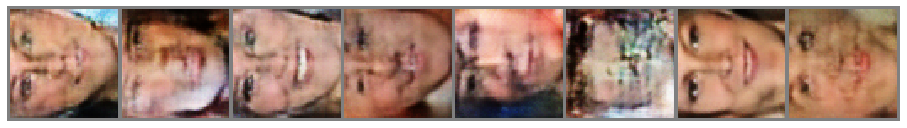

Epoch: 15
Discriminator_Error:  1.386317491531372  Generator_Error:  0.6929802894592285  Recons_Error:  0.08328374475240707
Discriminator_Error:  1.386322259902954  Generator_Error:  0.6945942044258118  Recons_Error:  0.0827936977148056
Discriminator_Error:  1.3863134384155273  Generator_Error:  0.6933228969573975  Recons_Error:  0.08963005244731903
Discriminator_Error:  1.3862946033477783  Generator_Error:  0.6939942836761475  Recons_Error:  0.08047406375408173
Discriminator_Error:  1.386286735534668  Generator_Error:  0.689866304397583  Recons_Error:  0.0821138471364975
Discriminator_Error:  1.3863887786865234  Generator_Error:  0.6937955617904663  Recons_Error:  0.08586599677801132
Discriminator_Error:  1.3863224983215332  Generator_Error:  0.6938621997833252  Recons_Error:  0.08290350437164307
Elapsed Time:  460.1673413515091


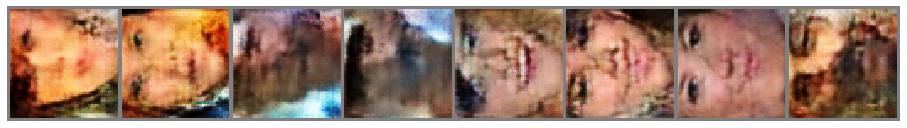

Epoch: 16
Discriminator_Error:  1.386321783065796  Generator_Error:  0.6939703822135925  Recons_Error:  0.08499616384506226
Discriminator_Error:  1.386318325996399  Generator_Error:  0.6946370601654053  Recons_Error:  0.08096849918365479
Discriminator_Error:  1.386350393295288  Generator_Error:  0.6925583481788635  Recons_Error:  0.08313068002462387
Discriminator_Error:  1.386339545249939  Generator_Error:  0.6922236680984497  Recons_Error:  0.08144642412662506
Discriminator_Error:  1.3863003253936768  Generator_Error:  0.6935039758682251  Recons_Error:  0.08311465382575989
Discriminator_Error:  1.3863122463226318  Generator_Error:  0.6931390762329102  Recons_Error:  0.0840945839881897
Discriminator_Error:  1.3862916231155396  Generator_Error:  0.6928601264953613  Recons_Error:  0.08480580896139145
Elapsed Time:  460.24520258342517


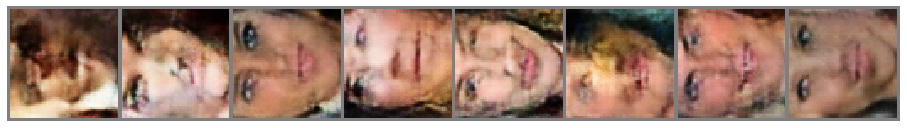

Epoch: 17
Discriminator_Error:  1.3862818479537964  Generator_Error:  0.6954447031021118  Recons_Error:  0.08073969930410385
Discriminator_Error:  1.3862699270248413  Generator_Error:  0.6937152147293091  Recons_Error:  0.07915389537811279
Discriminator_Error:  1.386364459991455  Generator_Error:  0.6914851069450378  Recons_Error:  0.08101525902748108
Discriminator_Error:  1.3863167762756348  Generator_Error:  0.693983793258667  Recons_Error:  0.08123727887868881
Discriminator_Error:  1.3862252235412598  Generator_Error:  0.6947574615478516  Recons_Error:  0.08054500818252563
Discriminator_Error:  1.386430263519287  Generator_Error:  0.6914692521095276  Recons_Error:  0.08637897670269012
Discriminator_Error:  1.3863162994384766  Generator_Error:  0.6932017803192139  Recons_Error:  0.0810348242521286
Elapsed Time:  460.3137115107642


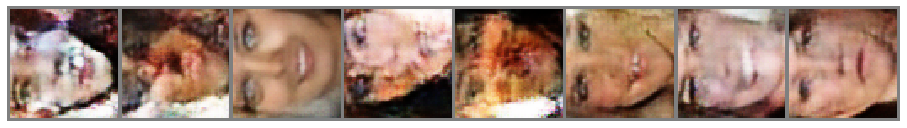

Epoch: 18
Discriminator_Error:  1.3864024877548218  Generator_Error:  0.6922953724861145  Recons_Error:  0.0818774625658989
Discriminator_Error:  1.3863102197647095  Generator_Error:  0.692423403263092  Recons_Error:  0.07830642908811569
Discriminator_Error:  1.3863208293914795  Generator_Error:  0.6925621032714844  Recons_Error:  0.07921102643013
Discriminator_Error:  1.3862744569778442  Generator_Error:  0.692867636680603  Recons_Error:  0.07898801565170288
Discriminator_Error:  1.3862700462341309  Generator_Error:  0.6963810920715332  Recons_Error:  0.08753948658704758
Discriminator_Error:  1.3864283561706543  Generator_Error:  0.691650927066803  Recons_Error:  0.08203534781932831
Discriminator_Error:  1.3863555192947388  Generator_Error:  0.6959038972854614  Recons_Error:  0.08197176456451416
Elapsed Time:  460.3382072323247


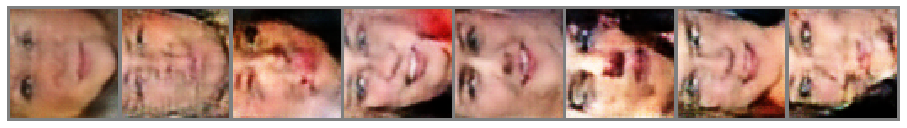

Epoch: 19
Discriminator_Error:  1.386303186416626  Generator_Error:  0.6924424171447754  Recons_Error:  0.07997377961874008
Discriminator_Error:  1.3862650394439697  Generator_Error:  0.6913034915924072  Recons_Error:  0.08043012022972107
Discriminator_Error:  1.3863298892974854  Generator_Error:  0.6911678314208984  Recons_Error:  0.0838010311126709
Discriminator_Error:  1.3862926959991455  Generator_Error:  0.6930553317070007  Recons_Error:  0.08041174709796906
Discriminator_Error:  1.3863201141357422  Generator_Error:  0.692250669002533  Recons_Error:  0.07734601944684982


TypeError: unsupported operand type(s) for /: 'Image' and 'int'

In [24]:
train(40,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load)

In [85]:
train_load